In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q torch
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertForQuestionAnswering
from datasets import load_dataset
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from sklearn.model_selection import StratifiedKFold
import os
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from transformers.utils import logging

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load and split data into test set
df = pd.read_csv('./drive/MyDrive/w266/project/labeled_data.csv')
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])

train_val_df.to_json("train.json", orient="records", lines=True)
test_df.to_json("test.json", orient="records", lines=True)

print(f"Training set: {len(train_val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 389 samples
Test set: 69 samples


In [12]:
# load ALBERT tokenizer and qa model trained on CoQA
tokenizer = AlbertTokenizer.from_pretrained("./drive/MyDrive/w266/project/model_checkpoints/coqa")

qa_model = AlbertForQuestionAnswering.from_pretrained("./drive/MyDrive/w266/model_checkpoints/coqa")



Some weights of the model checkpoint at ./drive/MyDrive/w266/model_checkpoints/coqa were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# set up for training
def preprocess_function(examples):
    return tokenizer(examples["question"], examples["response"], truncation=True, padding="max_length", max_length=512)

labels = train_val_df["label"].tolist()

num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [14]:
# weight classes due to imbalanced data set
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)

print(class_weights)


{0: np.float64(0.538781163434903), 1: np.float64(6.946428571428571)}


In [15]:
# add evaluation measures
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

In [16]:
# create instance of trainer class for weighted training
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.logits

          loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
          loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

          return (loss, outputs) if return_outputs else loss

In [17]:
# loop through folds for cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, labels)):
    print(f"Training on Fold {fold+1}/{num_folds}")

    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)

    model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
    model.albert.load_state_dict(qa_model.albert.state_dict(), strict=False )
    model.to(device)

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"./logs_fold_{fold}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    logging.set_verbosity_error()

    trainer.train()

    print(f"Evaluation for Fold {fold+1}")
    trainer.evaluate()

Training on Fold 1/4


Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-5e065f54578c>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.659578,0.918367,0.000000,0.000000,0.000000
2,No log,0.739565,0.928571,0.000000,0.000000,0.000000
3,No log,0.683972,0.918367,0.000000,0.000000,0.000000
4,No log,0.682988,0.918367,0.000000,0.000000,0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation for Fold 1


Training on Fold 2/4


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-5e065f54578c>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6884697079658508, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4368, 'eval_samples_per_second': 28.224, 'eval_steps_per_second': 2.037, 'epoch': 1.0}
{'eval_loss': 0.6818758249282837, 'eval_accuracy': 0.8969072164948454, 'eval_precision': 0.2, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.16666666666666666, 'eval_runtime': 3.4873, 'eval_samples_per_second': 27.815, 'eval_steps_per_second': 2.007, 'epoch': 2.0}
{'eval_loss': 0.7189916968345642, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.5, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.2222222222222222, 'eval_runtime': 3.4528, 'eval_samples_per_second': 28.093, 'eval_steps_per_second': 2.027, 'epoch': 3.0}
{'eval_loss': 0.7944433689117432, 'eval_accuracy': 0.9381443298969072, 'eval_precision': 1.0, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.25, 'eval_runtime': 3.4812, 'eval_samples_per_second': 27.864, 'eval_steps_per_second': 2

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-5e065f54578c>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.7012392282485962, 'eval_accuracy': 0.07216494845360824, 'eval_precision': 0.07216494845360824, 'eval_recall': 1.0, 'eval_f1': 0.1346153846153846, 'eval_runtime': 3.4932, 'eval_samples_per_second': 27.768, 'eval_steps_per_second': 2.004, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6955221891403198, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4645, 'eval_samples_per_second': 27.998, 'eval_steps_per_second': 2.02, 'epoch': 2.0}
{'eval_loss': 0.7130717635154724, 'eval_accuracy': 0.7010309278350515, 'eval_precision': 0.041666666666666664, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.06451612903225806, 'eval_runtime': 3.4853, 'eval_samples_per_second': 27.831, 'eval_steps_per_second': 2.008, 'epoch': 3.0}
{'eval_loss': 0.7349134683609009, 'eval_accuracy': 0.7938144329896907, 'eval_precision': 0.06666666666666667, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.09090909090909091, 'eval_runtime': 3.4554, 'eval_samples_per_second': 28.072, 'eval_steps_per_second': 2.026, 'epoch': 4.0}
{'train_runtime': 132.4703, 'train_samples_per_second': 8.817, 'train_steps_per_second': 0.574, 'train_loss': 0.6631162543045847, 'epoch': 4.0}
Evaluation for Fold 3
{'eval_loss': 0.7012392282485962,

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-5e065f54578c>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.6691351532936096, 'eval_accuracy': 0.9175257731958762, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4801, 'eval_samples_per_second': 27.873, 'eval_steps_per_second': 2.011, 'epoch': 1.0}
{'eval_loss': 0.7057202458381653, 'eval_accuracy': 0.6804123711340206, 'eval_precision': 0.038461538461538464, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.06060606060606061, 'eval_runtime': 3.5083, 'eval_samples_per_second': 27.649, 'eval_steps_per_second': 1.995, 'epoch': 2.0}
{'eval_loss': 0.6974647045135498, 'eval_accuracy': 0.9175257731958762, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4846, 'eval_samples_per_second': 27.837, 'eval_steps_per_second': 2.009, 'epoch': 3.0}
{'eval_loss': 0.7509216070175171, 'eval_accuracy': 0.9072164948453608, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4833, 'eval_samples_per_second': 27.847, 'eval_steps_per_second': 2.01, 'epoch': 4.0}
{'train_runt

In [18]:
# check misclassified examples
train_preds_output = trainer.predict(train_dataset)
train_logits = train_preds_output.predictions
train_preds = np.argmax(train_logits, axis=-1)
train_labels = train_preds_output.label_ids

val_preds_output = trainer.predict(val_dataset)
val_logits = val_preds_output.predictions
val_preds = np.argmax(val_logits, axis=-1)
val_labels = val_preds_output.label_ids

train_df = pd.DataFrame({"Actual": train_labels, "Predicted": train_preds})
val_df = pd.DataFrame({"Actual": val_labels, "Predicted": val_preds})

train_misclassified = train_df[train_df["Actual"] != train_df["Predicted"]]
print(f"Training Misclassified Examples:\n{train_misclassified}")

val_misclassified = val_df[val_df["Actual"] != val_df["Predicted"]]
print(f"\nValidation Misclassified Examples:\n{val_misclassified}")



Training Misclassified Examples:
     Actual  Predicted
1         0          1
4         0          1
5         0          1
18        0          1
26        0          1
39        0          1
40        0          1
48        0          1
54        0          1
68        0          1
69        0          1
70        0          1
75        0          1
88        1          0
91        0          1
101       0          1
105       0          1
107       0          1
108       0          1
113       1          0
120       0          1
123       0          1
127       1          0
134       0          1
135       0          1
138       0          1
140       0          1
141       0          1
142       0          1
146       0          1
161       0          1
162       0          1
169       0          1
173       0          1
174       1          0
196       0          1
197       0          1
198       0          1
199       0          1
205       0          1
211       0          1
2

In [20]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C/added_tokens.json')

In [21]:
train_dataset_final = Dataset.from_pandas(train_val_df).map(preprocess_function, batched=True)

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
model.albert.load_state_dict(qa_model.albert.state_dict(), strict=False )
model.to(device)

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_final,
    eval_dataset=train_dataset_final,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logging.set_verbosity_error()

trainer.train()

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-ba48a3ae6879>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6421357989311218, 'eval_accuracy': 0.9280205655526992, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 14.3485, 'eval_samples_per_second': 27.111, 'eval_steps_per_second': 3.415, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6649449467658997, 'eval_accuracy': 0.9280205655526992, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 13.0314, 'eval_samples_per_second': 29.851, 'eval_steps_per_second': 3.76, 'epoch': 2.0}
{'eval_loss': 0.6688607931137085, 'eval_accuracy': 0.8457583547557841, 'eval_precision': 0.16666666666666666, 'eval_recall': 0.2857142857142857, 'eval_f1': 0.21052631578947367, 'eval_runtime': 13.2763, 'eval_samples_per_second': 29.3, 'eval_steps_per_second': 3.691, 'epoch': 3.0}
{'eval_loss': 0.5800122618675232, 'eval_accuracy': 0.9074550128534704, 'eval_precision': 0.2777777777777778, 'eval_recall': 0.17857142857142858, 'eval_f1': 0.21739130434782608, 'eval_runtime': 13.25, 'eval_samples_per_second': 29.359, 'eval_steps_per_second': 3.698, 'epoch': 4.0}
{'eval_loss': 0.4907035827636719, 'eval_accuracy': 0.8303341902313625, 'eval_precision': 0.24324324324324326, 'eval_recall': 0.6428571428571429, 'eval_f1': 0.35294117647058826, 'eval_runtime': 13.2947, '

TrainOutput(global_step=200, training_loss=0.5613265228271485, metrics={'train_runtime': 420.4246, 'train_samples_per_second': 7.402, 'train_steps_per_second': 0.476, 'train_loss': 0.5613265228271485, 'epoch': 8.0})

In [22]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C2', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C2', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/A_Q_C2/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C2/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C2/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/A_Q_C2/added_tokens.json')

In [29]:
# check final misclassifications
all_preds_output = trainer.predict(train_dataset_final)
all_logits = all_preds_output.predictions
all_preds = np.argmax(all_logits, axis=-1)
all_labels = all_preds_output.label_ids


all_comparison = pd.DataFrame({"Actual": all_labels, "Predicted": all_preds})

all_misclassified = all_comparison[all_comparison["Actual"] != all_comparison["Predicted"]]

print(all_misclassified)

     Actual  Predicted
20        1          0
88        0          1
102       1          0
121       0          1
140       0          1
144       0          1
198       0          1
210       1          0
222       0          1
253       0          1


In [30]:
saved_model = "./drive/MyDrive/w266/project/model_checkpoints/A_Q_C2"
saved_tokenizer = "./drive/MyDrive/w266/project/model_checkpoints/A_Q_C2"

tokenizer = AlbertTokenizer.from_pretrained(saved_tokenizer)
model = AlbertForSequenceClassification.from_pretrained(saved_model, num_labels=2)


In [31]:
test_dataset = Dataset.from_pandas(test_df)

In [32]:
def predict(example):
    encoding = tokenizer(example['question'], example['response'],
                         truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

test_predictions = [predict(example) for example in test_dataset]

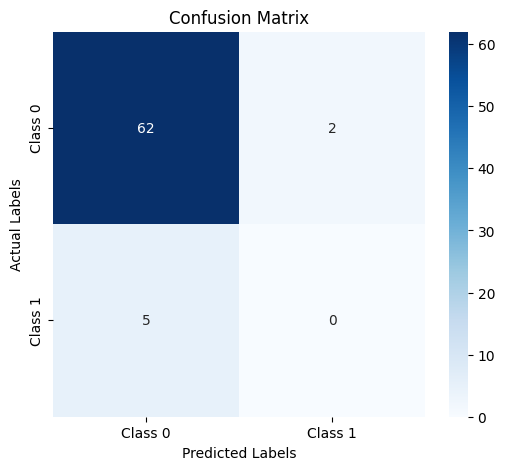

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = test_df['label'].to_list()

cm = confusion_matrix(labels, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
